<a href="https://colab.research.google.com/github/Rimo-rimo/boostcamp_AI/blob/main/DeepLearning_Basics/multi_head_attention_%EC%B5%9C%EC%A2%85%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/sjchoi86/upstage-basic-deeplearning/blob/main/notebook/mha.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/sjchoi86/upstage-basic-deeplearning/blob/main/notebook/mha.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View Source</a>
  </td>
</table>

# Multi-Head Attention

이번 과제에서는 Transformer에서 제안된 SDPA(Scaled Dot-Product Attention)과 MHA(Multi-Head Attention)를 구현해봅니다.

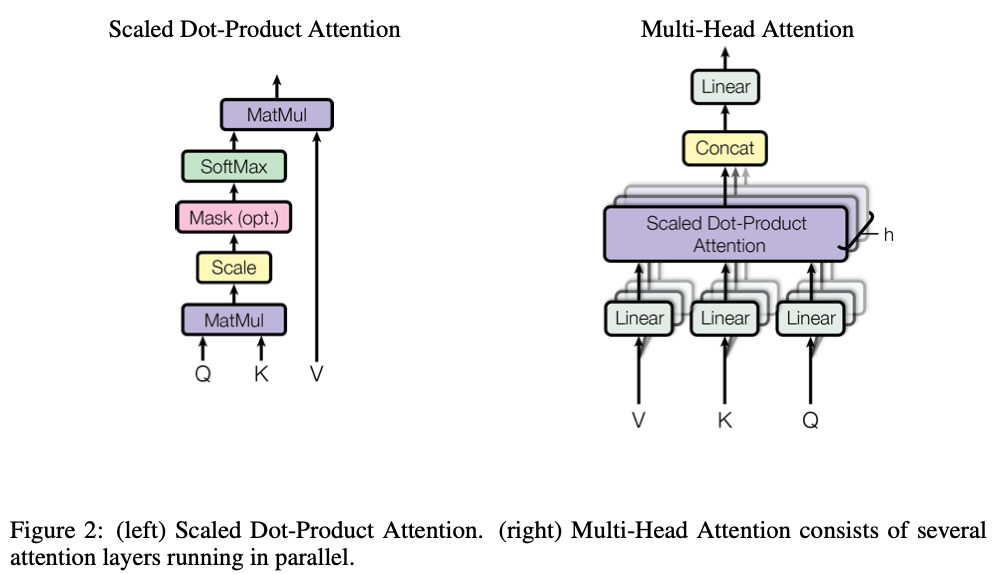

밑바닥부터 구현하는 것은 아니고 "FILL IN HERE" 부분을 채우시면 됩니다. 지워진 부분을 찾아서 코드를 작성한 후 실행해보세요. 이 과제는 따로 학습이 아닌 논문의 수식을 올바르게 구현하는게 목적입니다.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.10.0+cu111].
device:[cuda:0].


### Scaled Dot-Product Attention (SDPA)
- Data $X \in \mathbb{R}^{n \times d}$ where $n$ is the number data and $d$ is the data dimension
- Query and Key $Q, K \in \mathbb{R}^{n \times d_K}$ 
- Value $V \in \mathbb{R}^{n \times d_V} $

$\text{Attention}(Q,K,V) = \text{softmax} \left( \frac{QK^T}{\sqrt{d_K}} \right)V \in \mathbb{R}^{n \times d_V} $

In [3]:
class ScaledDotProductAttention(nn.Module):
    def forward(self,Q,K,V,mask=None):
        d_K = K.size()[-1] # key dimension
        scores = Q.matmul(K.transpose(-2,-1)) / np.sqrt(d_K)
        if mask is not None:
            scores = scores.masked_fill(mask==0, -1e9)
        attention = F.softmax(scores,dim=-1)
        out = attention.matmul(V)
        return out,attention

# Demo run of scaled dot product attention 
SPDA = ScaledDotProductAttention()
n_batch,d_K,d_V = 3,128,256 # d_K(=d_Q) does not necessarily be equal to d_V
n_Q,n_K,n_V = 30,50,50
Q = torch.rand(n_batch,n_Q,d_K)
K = torch.rand(n_batch,n_K,d_K)
V = torch.rand(n_batch,n_V,d_V)
out,attention = SPDA.forward(Q,K,V,mask=None)
def sh(x): return str(x.shape)[11:-1] 
print ("SDPA: Q%s K%s V%s => out%s attention%s"%
       (sh(Q),sh(K),sh(V),sh(out),sh(attention)))

# It supports 'multi-head' attention
n_batch,n_head,d_K,d_V = 3,5,128,256
n_Q,n_K,n_V = 30,50,50 # n_K and n_V should be the same
Q = torch.rand(n_batch,n_head,n_Q,d_K)
K = torch.rand(n_batch,n_head,n_K,d_K)
V = torch.rand(n_batch,n_head,n_V,d_V)
out,attention = SPDA.forward(Q,K,V,mask=None)
# out: [n_batch x n_head x n_Q x d_V]
# attention: [n_batch x n_head x n_Q x n_K] 
def sh(x): return str(x.shape)[11:-1] 
print ("(Multi-Head) SDPA: Q%s K%s V%s => out%s attention%s"%
       (sh(Q),sh(K),sh(V),sh(out),sh(attention)))

SDPA: Q[3, 30, 128] K[3, 50, 128] V[3, 50, 256] => out[3, 30, 256] attention[3, 30, 50]
(Multi-Head) SDPA: Q[3, 5, 30, 128] K[3, 5, 50, 128] V[3, 5, 50, 256] => out[3, 5, 30, 256] attention[3, 5, 30, 50]


### Multi-Head Attention (MHA)

$\text{head}_{\color{red}i} = \text{Attention}(Q {\color{green}W}^Q_{\color{red}i},K {\color{green}W}^K_{\color{red}i}, V {\color{green}W}^V_{\color{red}i}) $

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self,d_feat=128,n_head=5,actv=F.relu,USE_BIAS=True,dropout_p=0.1,device=None):
        """
        :param d_feat: feature dimension
        :param n_head: number of heads
        :param actv: activation after each linear layer
        :param USE_BIAS: whether to use bias
        :param dropout_p: dropout rate
        :device: which device to use (e.g., cuda:0)
        """
        super(MultiHeadAttention,self).__init__()
        if (d_feat%n_head) != 0:
            raise ValueError("d_feat(%d) should be divisible by b_head(%d)"%(d_feat,n_head)) 
        self.d_feat = d_feat
        self.n_head = n_head
        self.d_head = self.d_feat // self.n_head
        self.actv = actv
        self.USE_BIAS = USE_BIAS
        self.dropout_p = dropout_p # prob. of zeroed

        self.lin_Q = nn.Linear(self.d_feat,self.d_feat,self.USE_BIAS)
        self.lin_K = nn.Linear(self.d_feat,self.d_feat,self.USE_BIAS)
        self.lin_V = nn.Linear(self.d_feat,self.d_feat,self.USE_BIAS)
        self.lin_O = nn.Linear(self.d_feat,self.d_feat,self.USE_BIAS)

        self.dropout = nn.Dropout(p=self.dropout_p)
    
    def forward(self,Q,K,V,mask=None):
        """
        :param Q: [n_batch, n_Q, d_feat]
        :param K: [n_batch, n_K, d_feat]
        :param V: [n_batch, n_V, d_feat] <= n_K and n_V must be the same 
        :param mask: 
        """
        n_batch = Q.shape[0]
        Q_feat = self.lin_Q(Q) 
        K_feat = self.lin_K(K) 
        V_feat = self.lin_V(V)
        # Q_feat: [n_batch, n_Q, d_feat]
        # K_feat: [n_batch, n_K, d_feat]
        # V_feat: [n_batch, n_V, d_feat]

        # Multi-head split of Q, K, and V (d_feat = n_head*d_head)
        Q_split = Q_feat.view(n_batch, -1, self.n_head, self.d_head).permute(0, 2, 1, 3)
        K_split = K_feat.view(n_batch, -1, self.n_head, self.d_head).permute(0, 2, 1, 3)
        V_split = V_feat.view(n_batch, -1, self.n_head, self.d_head).permute(0, 2, 1, 3)
        # Q_split: [n_batch, n_head, n_Q, d_head]
        # K_split: [n_batch, n_head, n_K, d_head]
        # V_split: [n_batch, n_head, n_V, d_head]

        # Multi-Head Attention
        d_K = K.size()[-1] # key dimension
        scores = torch.matmul(Q_split, K_split.permute(0,1,3,2)) / np.sqrt(d_K)
        if mask is not None:
            scores = scores.masked_fill(mask==0,-1e9)
        attention = torch.softmax(scores,dim=-1)
        x_raw = torch.matmul(self.dropout(attention),V_split) # dropout is NOT mentioned in the paper
        # attention: [n_batch, n_head, n_Q, n_K]
        # x_raw: [n_batch, n_head, n_Q, d_head]

        # Reshape x
        x_rsh1 = x_raw.permute(0,2,1,3).contiguous()
        # x_rsh1: [n_batch, n_Q, n_head, d_head]
        x_rsh2 = x_rsh1.view(n_batch,-1,self.d_feat)
        # x_rsh2: [n_batch, n_Q, d_feat]

        # Linear
        x = self.lin_O(x_rsh2)
        # x: [n_batch, n_Q, d_feat]
        out = {'Q_feat':Q_feat,'K_feat':K_feat,'V_feat':V_feat,
               'Q_split':Q_split,'K_split':K_split,'V_split':V_split,
               'scores':scores,'attention':attention,
               'x_raw':x_raw,'x_rsh1':x_rsh1,'x_rsh2':x_rsh2,'x':x}
        return out

# Self-Attention Layer
n_batch = 128
n_src   = 32
d_feat  = 200
n_head  = 5
src = torch.rand(n_batch,n_src,d_feat)
self_attention = MultiHeadAttention(
    d_feat=d_feat,n_head=n_head,actv=F.relu,USE_BIAS=True,dropout_p=0.1,device=device)
out = self_attention.forward(src,src,src,mask=None)

Q_feat,K_feat,V_feat = out['Q_feat'],out['K_feat'],out['V_feat']
Q_split,K_split,V_split = out['Q_split'],out['K_split'],out['V_split']
scores,attention = out['scores'],out['attention']
x_raw,x_rsh1,x_rsh2,x = out['x_raw'],out['x_rsh1'],out['x_rsh2'],out['x']

# Print out shapes
def sh(_x): return str(_x.shape)[11:-1] 
print ("Input src:\t%s  \t= [n_batch, n_src, d_feat]"%(sh(src)))
print ()
print ("Q_feat:   \t%s  \t= [n_batch, n_src, d_feat]"%(sh(Q_feat)))
print ("K_feat:   \t%s  \t= [n_batch, n_src, d_feat]"%(sh(K_feat)))
print ("V_feat:   \t%s  \t= [n_batch, n_src, d_feat]"%(sh(V_feat)))
print ()
print ("Q_split:  \t%s  \t= [n_batch, n_head, n_src, d_head]"%(sh(Q_split)))
print ("K_split:  \t%s  \t= [n_batch, n_head, n_src, d_head]"%(sh(K_split)))
print ("V_split:  \t%s  \t= [n_batch, n_head, n_src, d_head]"%(sh(V_split)))
print ()
print ("scores:   \t%s  \t= [n_batch, n_head, n_src, n_src]"%(sh(scores)))
print ("attention:\t%s  \t= [n_batch, n_head, n_src, n_src]"%(sh(attention)))
print ()
print ("x_raw:    \t%s  \t= [n_batch, n_head, n_src, d_head]"%(sh(x_raw)))
print ("x_rsh1:   \t%s  \t= [n_batch, n_src, n_head, d_head]"%(sh(x_rsh1)))
print ("x_rsh2:   \t%s  \t= [n_batch, n_src, d_feat]"%(sh(x_rsh2)))
print ()
print ("Output x: \t%s  \t= [n_batch, n_src, d_feat]"%(sh(x)))


Input src:	[128, 32, 200]  	= [n_batch, n_src, d_feat]

Q_feat:   	[128, 32, 200]  	= [n_batch, n_src, d_feat]
K_feat:   	[128, 32, 200]  	= [n_batch, n_src, d_feat]
V_feat:   	[128, 32, 200]  	= [n_batch, n_src, d_feat]

Q_split:  	[128, 5, 32, 40]  	= [n_batch, n_head, n_src, d_head]
K_split:  	[128, 5, 32, 40]  	= [n_batch, n_head, n_src, d_head]
V_split:  	[128, 5, 32, 40]  	= [n_batch, n_head, n_src, d_head]

scores:   	[128, 5, 32, 32]  	= [n_batch, n_head, n_src, n_src]
attention:	[128, 5, 32, 32]  	= [n_batch, n_head, n_src, n_src]

x_raw:    	[128, 5, 32, 40]  	= [n_batch, n_head, n_src, d_head]
x_rsh1:   	[128, 32, 5, 40]  	= [n_batch, n_src, n_head, d_head]
x_rsh2:   	[128, 32, 200]  	= [n_batch, n_src, d_feat]

Output x: 	[128, 32, 200]  	= [n_batch, n_src, d_feat]
